# Test Out-of-box Model on [Fatura2 Invoice Dataset](https://huggingface.co/datasets/mathieu1256/FATURA2-invoices)

This notebook demonstrates how to use the out-of-box model to predict the entities in the Fatura2 Invoice Dataset. The dataset is available in the Hugging Face Datasets library. The model used in this notebook is a pre-trained model from the Hugging Face model hub.

Note that the licence of the dataset is CC-BY-SA 4.0. Please refer to the [dataset page](https://huggingface.co/datasets/mathieu1256/FATURA2-invoices) for more details.

In [84]:
from collections import Counter

import mlflow
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoImageProcessor, pipeline
import lovely_tensors as lt

from src.config import init_config

## Configuration and settings

In [15]:
# monkey path the tensor printing
lt.monkey_patch()

In [3]:
# Initialize config
config = init_config()
print(config)

data:
  dataset_name: mathieu1256/FATURA2-invoices
models:
  classification:
    oob:
      pt: microsoft/dit-base
      ft: microsoft/dit-base-finetuned-rvlcdip
mlflow:
  tracking_uri: .mlflow
  experiments:
    classification: invoice-classification



In [4]:
# Set MLflow tracking URI (folder where the experiments will be saved)
mlflow.set_tracking_uri(config.mlflow.tracking_uri)

In [5]:
# Set the experiment
mlflow.set_experiment(config.mlflow.experiments.classification)

<Experiment: artifact_location='/home/david/projects/InvoiceXpert/.mlflow/578366056655146815', creation_time=1708679257151, experiment_id='578366056655146815', last_update_time=1708679257151, lifecycle_stage='active', name='invoice-classification', tags={}>

## Load data and models 

In [6]:
# Load the dataset
invoice_df = load_dataset(config.data.dataset_name)

In [ ]:
# Load the image processor
processor = AutoImageProcessor.from_pretrained(config.models.classification.oob.pt)

In [ ]:
ft_model = AutoModelForImageClassification.from_pretrained(config.models.classification.oob.ft)

## Test the dataset and model
On one sample from the dataset, we will test the model to see how it performs.

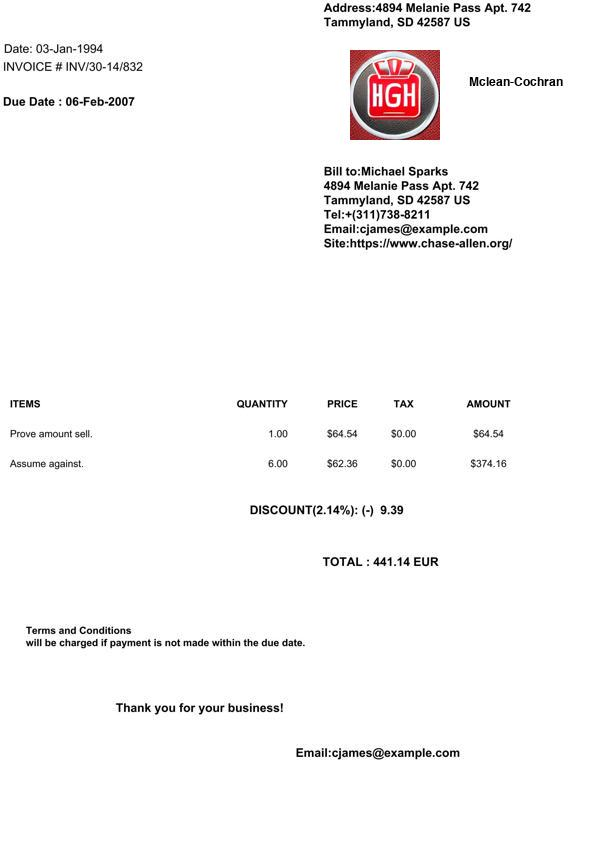

In [12]:
# Show sample image
test_image = invoice_df["test"][0]["image"]
test_image

In [37]:
test_image = invoice_df["test"][0]["image"]

In [39]:
test_pixels = processor(test_image, return_tensors="pt")
test_pixels

{'pixel_values': tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-0.976, 1.000] μ=0.941 σ=0.215}

In [43]:
# test the model
output = ft_model(**test_pixels)
output

ImageClassifierOutput(loss=None, logits=tensor[1, 16] x∈[-0.475, 4.597] μ=0.007 σ=1.255 grad AddmmBackward0, hidden_states=None, attentions=None)

In [46]:
output.logits

tensor[1, 16] x∈[-0.475, 4.597] μ=0.007 σ=1.255 grad AddmmBackward0

In [48]:
output.logits.argmax(dim=-1)

tensor[1] i64 [11]

In [54]:
ft_model.config.id2label[output.logits.argmax(dim=-1).item()]

'invoice'

## Model evaluation

### Pipeline on test example

In [68]:
pipe = pipeline("image-classification", model=ft_model, image_processor=processor, device="cuda")

In [70]:
pipe(test_image, top_k=1)

[{'label': 'invoice', 'score': 0.8944647312164307}]

In [74]:
results_raw = pipe(invoice_df["train"][:1000]["image"], batch_size=16, top_k=1)

In [82]:
# extract the labels
results = [result[0]["label"] for result in results_raw]


In [83]:
# count the labels
label_counts = Counter(results)

In [85]:
label_counts

Counter({'invoice': 964, 'budget': 29, 'letter': 6, 'specification': 1})